# IE 423 - PROJECT PART 3 - MUSTAFA & BENGİSU & FETHİ

In [88]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import cv2
from skimage import io, img_as_float
from skimage.filters import gaussian

In [89]:
image_path = '0048.jpg'
color_image = Image.open(image_path)
gray_image = color_image.convert('L')
gray_image_array = np.array(gray_image)

# Question 3.1.1.

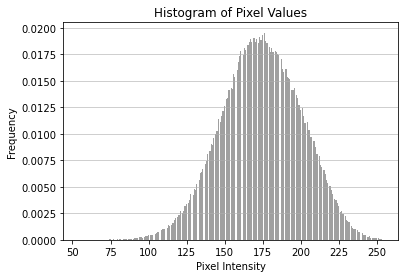

In [90]:
# Get pixel values
pixel_values = np.array(gray_image).flatten()

# Plot histogram of pixel values
plt.hist(pixel_values, bins=256, density=True, color='gray', alpha=0.75)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Question 3.1.2.

In [91]:
# Descriptive statistics
mean_pixel_value = np.mean(pixel_values)
median_pixel_value = np.median(pixel_values)
mode_pixel_value = stats.mode(pixel_values)[0][0]
variance_pixel_value = np.var(pixel_values)
std_dev_pixel_value = np.std(pixel_values)
min_pixel_value = np.min(pixel_values)
max_pixel_value = np.max(pixel_values)

# Skewness and Kurtosis
skewness = stats.skew(pixel_values)
kurtosis = stats.kurtosis(pixel_values)

# Compile the results
descriptive_statistics = {
    "Max": max_pixel_value,
    "Min": min_pixel_value,
    "Mean": mean_pixel_value,
    "Median": median_pixel_value,
    "Mode": mode_pixel_value,
    "Variance": variance_pixel_value,
    "Standard Deviation": std_dev_pixel_value,
    "Skewness": skewness,
    "Kurtosis": kurtosis
}

descriptive_statistics

{'Max': 254,
 'Min': 54,
 'Mean': 174.2226905822754,
 'Median': 174.0,
 'Mode': 176,
 'Variance': 683.0998725581303,
 'Standard Deviation': 26.13617937951395,
 'Skewness': -0.09420668731254551,
 'Kurtosis': -0.1628147016078514}

In [92]:
# Normal Distribution parameters (we use the mean and std dev calculated previously)
normal_dist = stats.norm(loc=mean_pixel_value, scale=std_dev_pixel_value)

# Uniform Distribution parameters (spanning the observed range of pixel values)
uniform_dist = stats.uniform(loc=min_pixel_value, scale=max_pixel_value - min_pixel_value)

# Perform Kolmogorov-Smirnov test for Normal Distribution
ks_test_normal = stats.kstest(pixel_values, normal_dist.cdf)

# Perform Kolmogorov-Smirnov test for Uniform Distribution
ks_test_uniform = stats.kstest(pixel_values, uniform_dist.cdf)

# Compile the results
ks_test_results = {
    "Normal Distribution": {
        "K-S Statistic": ks_test_normal[0],
        "p-value": ks_test_normal[1]
    },
    "Uniform Distribution": {
        "K-S Statistic": ks_test_uniform[0],
        "p-value": ks_test_uniform[1]
    }
}

ks_test_results

{'Normal Distribution': {'K-S Statistic': 0.015121972533821526,
  'p-value': 1.6827617768595736e-52},
 'Uniform Distribution': {'K-S Statistic': 0.3394471740722656, 'p-value': 0.0}}

# Question 3.1.3.

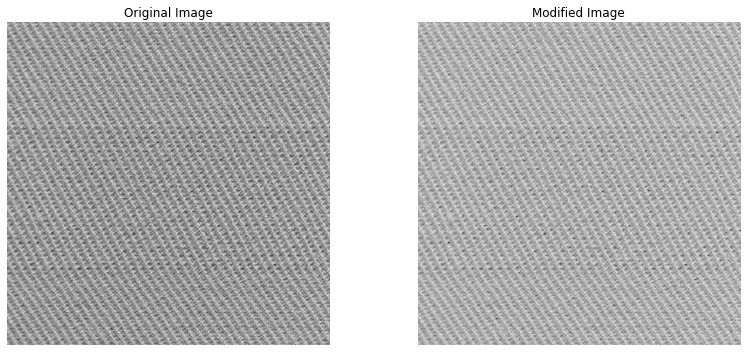

(93.45582470390436, 254.98955646064644)

In [93]:
# Calculate the z-score for 0.001 probability limit on each tail
# Using the percent point function (ppf) to find the inverse cdf value for the probabilities
lower_bound = normal_dist.ppf(0.001)
upper_bound = normal_dist.ppf(1-0.001)

# Identify the pixels that are out of the 0.001 probability limits
outliers = np.where((pixel_values < lower_bound) | (pixel_values > upper_bound))

# Create a copy of the pixel values to modify
modified_pixel_values = pixel_values.copy()

# Change the value of these pixels to zero (black color)
modified_pixel_values[outliers] = 0

# Reshape the modified pixels back to the original image dimensions
modified_image_array = modified_pixel_values.reshape(gray_image.size[1], gray_image.size[0])
modified_image = Image.fromarray(modified_image_array)

# Display the original and the modified image side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original image
ax[0].imshow(gray_image, cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')

# Modified image
ax[1].imshow(modified_image, cmap='gray')
ax[1].title.set_text('Modified Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Return the lower and upper bounds for reference
lower_bound, upper_bound

The original image and the modified image are displayed side by side. In the modified image, pixels that fell outside the 0.001 probability limits of the assumed normal distribution have been changed to black. The calculated bounds for these limits are approximately 93.46 for the lower bound and 254.99 for the upper bound.

Observations:

The original image looks to be fairly light in color overall, which is consistent with the mean pixel value being on the higher side (174.22).
In the modified image, we can see that only a few pixels have been turned black, suggesting that there were not many pixels with values below the lower bound or above the upper bound. This means there were few extreme values in the pixel data.
The fact that there are few black pixels in the modified image indicates that the bulk of the pixel values were within the middle 99.8% of the assumed normal distribution.

Findings:

The majority of the pixel values are concentrated around the mean, which is typical for a distribution that has light tails, as indicated by the kurtosis value close to zero.
The outliers that were changed to black are not visibly prominent in the modified image, which could mean that these outlier pixels were scattered and not clustered in any particular region of the image.
This approach of modifying outlier pixels could be a rudimentary method for noise reduction in image processing if the assumption of normal distribution holds for the particular application. However, caution should be taken since, in this case, the normal distribution was not a perfect fit for the pixel value distribution.
By changing outlier pixel values to black, we've essentially applied a very simple form of thresholding. This could be useful in image processing tasks where identifying or removing outliers is necessary, but more sophisticated methods would typically be used in practice to avoid assuming a normal distribution where it may not apply.

# Question 3.1.4.

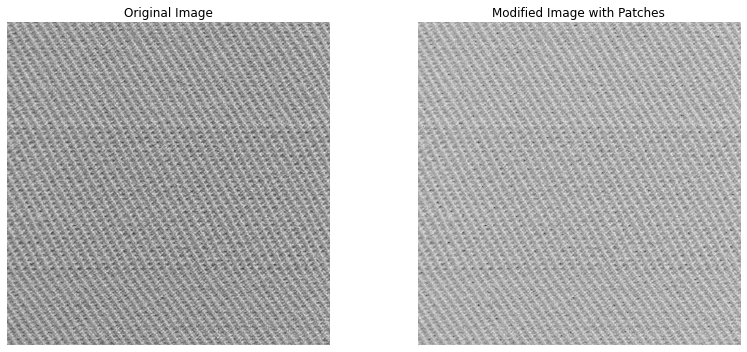

In [94]:
# Define the window size
window_size = (51, 51)

# Calculate the number of windows in each dimension
num_windows_x = gray_image.size[0] // window_size[0]
num_windows_y = gray_image.size[1] // window_size[1]

# Create a copy of the pixel array to modify
modified_pixel_values_patch = np.array(gray_image)

# Process each patch
for i in range(num_windows_x):
    for j in range(num_windows_y):
        # Define the window boundaries
        start_x = i * window_size[0]
        start_y = j * window_size[1]
        end_x = start_x + window_size[0]
        end_y = start_y + window_size[1]
        
        # Extract the patch
        patch = modified_pixel_values_patch[start_y:end_y, start_x:end_x]
        
        # Flatten the patch and calculate its statistics
        patch_values = patch.flatten()
        patch_mean = np.mean(patch_values)
        patch_std = np.std(patch_values)
        
        # Create a normal distribution for the patch
        patch_dist = stats.norm(loc=patch_mean, scale=patch_std)
        
        # Calculate the bounds for 0.001 probability limits
        patch_lower_bound = patch_dist.ppf(0.001)
        patch_upper_bound = patch_dist.ppf(1-0.001)
        
        # Identify and blacken outliers in the patch
        outliers = np.where((patch_values < patch_lower_bound) | (patch_values > patch_upper_bound))
        patch_values[outliers] = 0
        
        # Reshape the patch and put it back into the image
        modified_patch = patch_values.reshape(window_size[1], window_size[0])
        modified_pixel_values_patch[start_y:end_y, start_x:end_x] = modified_patch

# Convert the modified pixels to an image
modified_image_patches = Image.fromarray(modified_pixel_values_patch)

# Display the original and the modified image with patches processed
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original image
ax[0].imshow(gray_image, cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')

# Modified image with patches processed
ax[1].imshow(modified_image_patches, cmap='gray')
ax[1].title.set_text('Modified Image with Patches')
ax[1].axis('off')

plt.tight_layout()
plt.show()

The original image is shown alongside the modified image where outlier pixels in each 51x51 patch have been turned black.

Observations:

The modified image with patches processed reveals a more pronounced pattern of black pixels compared to the earlier whole-image processing. This suggests that the local variances within each patch were taken into account, leading to the identification of different outliers than when considering the global distribution.
The pattern of black pixels in the modified image does not appear to be random but seems to be somewhat regularly distributed across the image, which could indicate that the outliers are related to specific features or textures within the local patches.
Findings:

This localized approach can be more sensitive to the nuances within small areas of an image, which is particularly useful in tasks such as texture analysis, anomaly detection, or image segmentation.
By applying the thresholding operation on a per-patch basis, we've effectively adapted to local variations in pixel intensity, which might be more reflective of the actual content and structure within the image.
The resulting black pixels in each patch show where the extreme values lie relative to the local statistics of that patch, not the global statistics of the entire image.
This method, while more computationally intensive, can provide a more detailed analysis and potentially better results for certain applications where local context is crucial. However, it also may highlight the importance of choosing the right window size for analysis, as different sizes could significantly affect the identification of outliers. 

In the modified image where the global distribution was used to identify outliers, 323 pixels were turned black.

In the modified image where each 51x51 patch was processed individually, 286 pixels were turned black.

It is interesting to note that the number of black pixels is slightly higher when considering the image as a whole compared to processing it in patches. This might be due to the fact that local variations within patches can sometimes mask the presence of outliers when using a global threshold, whereas a localized approach adjusts the threshold based on the specific distribution of each patch, potentially resulting in fewer outliers relative to the local context.

In [95]:
# Count the number of black pixels in the modified image from the global operation
black_pixels_global = np.sum(modified_pixel_values == 0)

# Count the number of black pixels in the modified image from the local patch operation
black_pixels_patch = np.sum(modified_pixel_values_patch == 0)

black_pixels_global, black_pixels_patch

(323, 286)

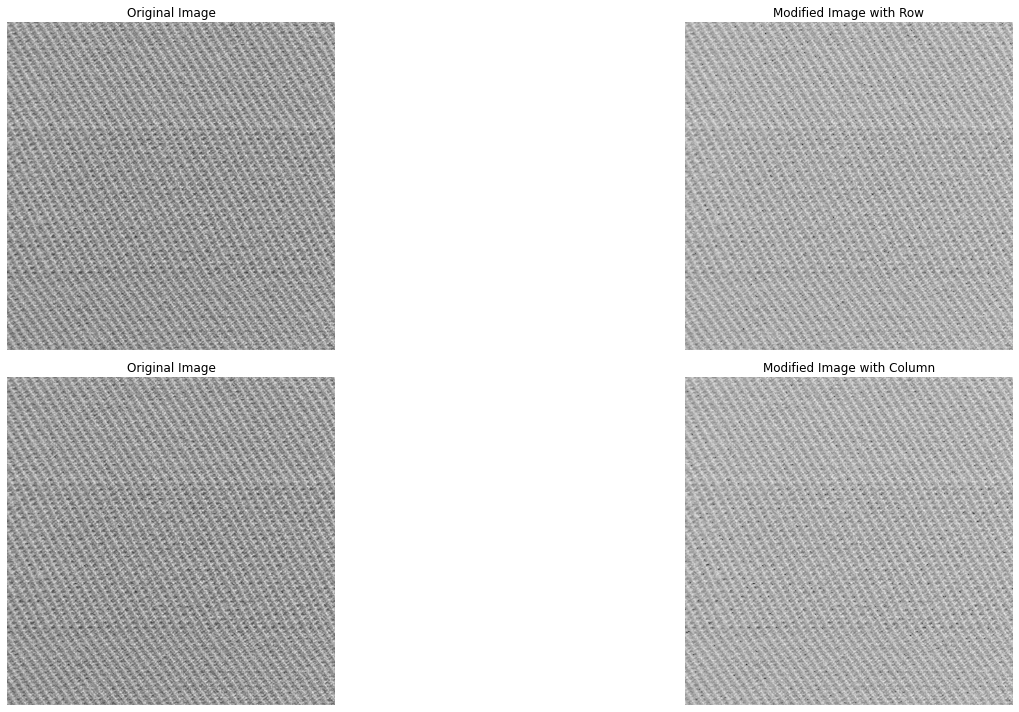

In [96]:
# Convert grayscale image to numpy array
gray_array = np.array(gray_image)

# Calculate mean and variance for each row
row_means = np.mean(gray_array, axis=1)
row_variances = np.var(gray_array, axis=1)

# Calculate mean and variance for each column
col_means = np.mean(gray_array, axis=0)
col_variances = np.var(gray_array, axis=0)

# Find the 0.01 probability threshold values for black
threshold_row = np.percentile(gray_array, 0.01, axis=1)
threshold_col = np.percentile(gray_array, 0.01, axis=0)

# Apply threshold to rows and columns to create new images
row_black_thresholded = np.where(gray_array < threshold_row[:, None], 0, gray_array)
col_black_thresholded = np.where(gray_array < threshold_col, 0, gray_array)

# Convert arrays back to images
row_black_image = Image.fromarray(row_black_thresholded.astype(np.uint8))
col_black_image = Image.fromarray(col_black_thresholded.astype(np.uint8))

# Display the original and the modified image with patches processed
fig, ax = plt.subplots(2, 2, figsize=(24, 10))

# Original image
ax[0][0].imshow(gray_image, cmap='gray')
ax[0][0].title.set_text('Original Image')
ax[0][0].axis('off')

# Modified image with patches processed
ax[0][1].imshow(row_black_image, cmap='gray')
ax[0][1].title.set_text('Modified Image with Row')
ax[0][1].axis('off')

# Original image
ax[1][0].imshow(gray_image, cmap='gray')
ax[1][0].title.set_text('Original Image')
ax[1][0].axis('off')

# Modified image with patches processed
ax[1][1].imshow(col_black_image, cmap='gray')
ax[1][1].title.set_text('Modified Image with Column')
ax[1][1].axis('off')

plt.tight_layout()
plt.show()

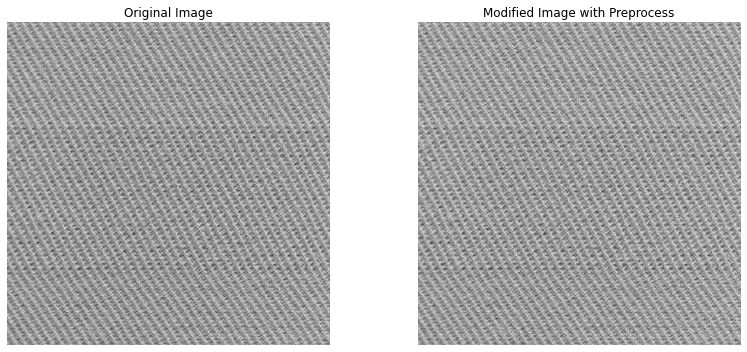

In [97]:
def preprocess_image(image_path):
    # Load the image
    image = io.imread(image_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return img_as_float(gray_image)

image_path = '0048.jpg'
preprocessed_image = preprocess_image(image_path)

# Display the original and the modified image with patches processed
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original image
ax[0].imshow(gray_image, cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')

# Modified image with patches processed
ax[1].imshow(preprocessed_image, cmap='gray')
ax[1].title.set_text('Modified Image with Preprocess')
ax[1].axis('off')

plt.tight_layout()
plt.show()

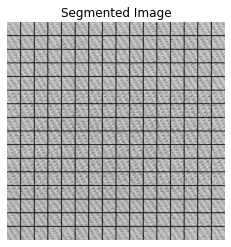

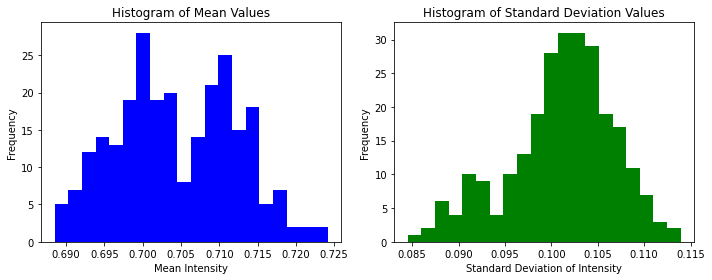

([0.7104587928921569,
  0.713101256127451,
  0.7117264093137254,
  0.7106119791666666,
  0.7131127450980392],
 [0.08809036677699356,
  0.08632141502478623,
  0.09035710516281267,
  0.09717430389173706,
  0.10026509640398892])

In [98]:
# Define the grid size for segmentation (number of segments along x and y axis)
grid_size_x = 16
grid_size_y = 16

# Calculate the size of each segment
segment_size_x = preprocessed_image.shape[1] // grid_size_x
segment_size_y = preprocessed_image.shape[0] // grid_size_y

# Initialize lists to hold the features for each segment
mean_values = []
std_dev_values = []

# Segment the image and calculate features for each segment
for i in range(grid_size_y):
    for j in range(grid_size_x):
        # Define the segment boundaries
        start_x = j * segment_size_x
        end_x = (j + 1) * segment_size_x
        start_y = i * segment_size_y
        end_y = (i + 1) * segment_size_y
        
        # Extract the segment
        segment = preprocessed_image[start_y:end_y, start_x:end_x]
        
        # Calculate features (mean and standard deviation for now)
        segment_mean = np.mean(segment)
        segment_std = np.std(segment)
        
        # Append the calculated features to our lists
        mean_values.append(segment_mean)
        std_dev_values.append(segment_std)

# For the purpose of visualization, let's also create an image showing the grid
segmented_image = preprocessed_image.copy()
for i in range(1, grid_size_y):
    segmented_image[i * segment_size_y - 1:i * segment_size_y + 1, :] = 0
for j in range(1, grid_size_x):
    segmented_image[:, j * segment_size_x - 1:j * segment_size_x + 1] = 0

# Now we display the segmented image
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()

# Let's show the mean values as an example of the features extracted
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(mean_values, bins=20, color='blue')
plt.title('Histogram of Mean Values')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(std_dev_values, bins=20, color='green')
plt.title('Histogram of Standard Deviation Values')
plt.xlabel('Standard Deviation of Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# For the purpose of the example, we will just return the first few mean and standard deviation values
mean_values[:5], std_dev_values[:5]

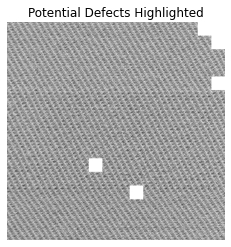

(0.7200145990576943,
 0.6889367750710587,
 [(0, 32, 448, 480),
  (0, 32, 480, 512),
  (32, 64, 480, 512),
  (128, 160, 480, 512),
  (320, 352, 192, 224)])

In [99]:
# Establishing baseline statistics from the current image
# In practice, these would come from a set of known good images
baseline_mean = np.mean(mean_values)
baseline_std = np.std(mean_values)

# Calculate control limits for mean intensity (assuming a normal distribution)
# We will set control limits at ±3 standard deviations from the mean
upper_control_limit = baseline_mean +  2*baseline_std
lower_control_limit = baseline_mean -  2*baseline_std

# Anomaly Detection: Identify segments that fall outside the control limits
defects_image = preprocessed_image.copy()
defects_locations = []

for i, (mean_val, std_val) in enumerate(zip(mean_values, std_dev_values)):
    if mean_val < lower_control_limit or mean_val > upper_control_limit:
        # Calculate the segment's position in the image
        row = i // grid_size_x
        col = i % grid_size_x
        start_x = col * segment_size_x
        end_x = (col + 1) * segment_size_x
        start_y = row * segment_size_y
        end_y = (row + 1) * segment_size_y
        
        # Save the defect location for visualization
        defects_locations.append((start_y, end_y, start_x, end_x))
        
        # Highlight the defect segment
        defects_image[start_y:end_y, start_x:end_x] = np.max(preprocessed_image)

# Display the image with potential defects highlighted
plt.imshow(defects_image, cmap='gray')
plt.title('Potential Defects Highlighted')
plt.axis('off')
plt.show()

# Return control limits and the locations of the first few potential defects
upper_control_limit, lower_control_limit, defects_locations[:5]

In [100]:
# Testing our propsal for random 5 images
def random_test():
    counter = 0
    while counter < 5:
        try:
            random_int = np.random.randint(1, 196)
            string = ("0" * (4-len(str(random_int)))) + str(random_int)
            
            image_path = f'{string}.jpg'
            preprocessed_image = preprocess_image(image_path)
        except:
            continue
        counter += 1
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        # Display the preprocessed image
        plt.subplot(1, 2, 1)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title('Preprocessed Image')
        plt.axis('off')
        
        # Define the grid size for segmentation (number of segments along x and y axis)
        grid_size_x = 32
        grid_size_y = 32

        # Calculate the size of each segment
        segment_size_x = preprocessed_image.shape[1] // grid_size_x
        segment_size_y = preprocessed_image.shape[0] // grid_size_y

        # Initialize lists to hold the features for each segment
        mean_values = []
        std_dev_values = []

        # Segment the image and calculate features for each segment
        for i in range(grid_size_y):
            for j in range(grid_size_x):
                # Define the segment boundaries
                start_x = j * segment_size_x
                end_x = (j + 1) * segment_size_x
                start_y = i * segment_size_y
                end_y = (i + 1) * segment_size_y

                # Extract the segment
                segment = preprocessed_image[start_y:end_y, start_x:end_x]

                # Calculate features (mean and standard deviation for now)
                segment_mean = np.mean(segment)
                segment_std = np.std(segment)

                # Append the calculated features to our lists
                mean_values.append(segment_mean)
                std_dev_values.append(segment_std)

        # Establishing baseline statistics from the current image
        # In practice, these would come from a set of known good images
        baseline_mean = np.mean(mean_values)
        baseline_std = np.std(mean_values)

        # Calculate control limits for mean intensity (assuming a normal distribution)
        # We will set control limits at ±3 standard deviations from the mean
        upper_control_limit = baseline_mean +  2*baseline_std
        lower_control_limit = baseline_mean -  2*baseline_std

        # Anomaly Detection: Identify segments that fall outside the control limits
        defects_image = preprocessed_image.copy()
        defects_locations = []

        for i, (mean_val, std_val) in enumerate(zip(mean_values, std_dev_values)):
            if mean_val < lower_control_limit or mean_val > upper_control_limit:
                # Calculate the segment's position in the image
                row = i // grid_size_x
                col = i % grid_size_x
                start_x = col * segment_size_x
                end_x = (col + 1) * segment_size_x
                start_y = row * segment_size_y
                end_y = (row + 1) * segment_size_y

                # Save the defect location for visualization
                defects_locations.append((start_y, end_y, start_x, end_x))

                # Highlight the defect segment
                defects_image[start_y:end_y, start_x:end_x] = np.max(preprocessed_image)

        # Display the image with potential defects highlighted
        plt.subplot(1, 2, 2)
        plt.imshow(defects_image, cmap='gray')
        plt.title('Potential Defects Highlighted')
        plt.axis('off')
        
        # Adjust layout
        plt.tight_layout()
        
        plt.show()

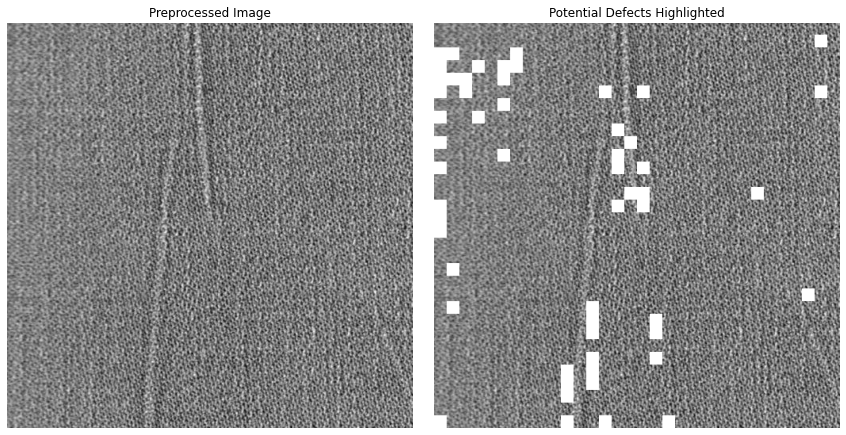

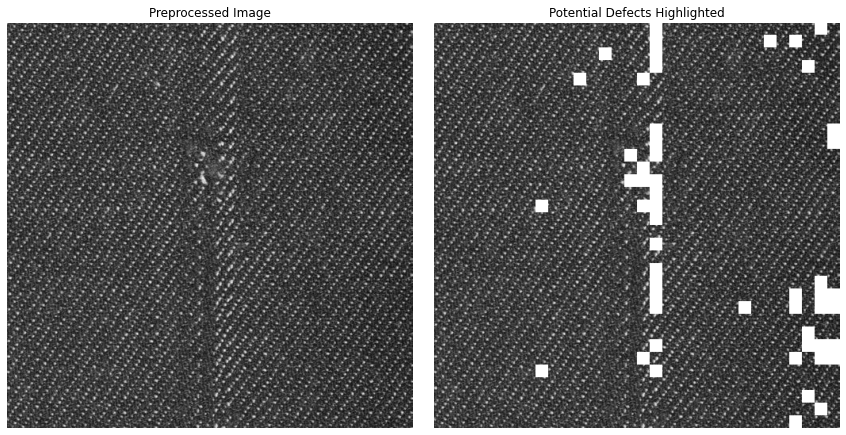

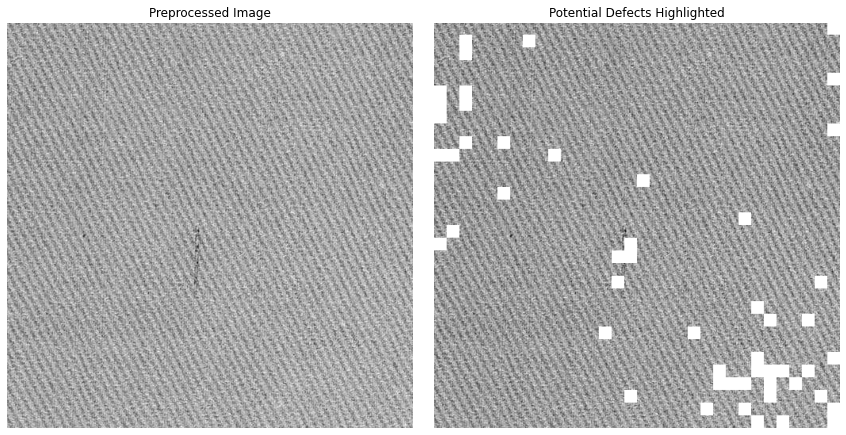

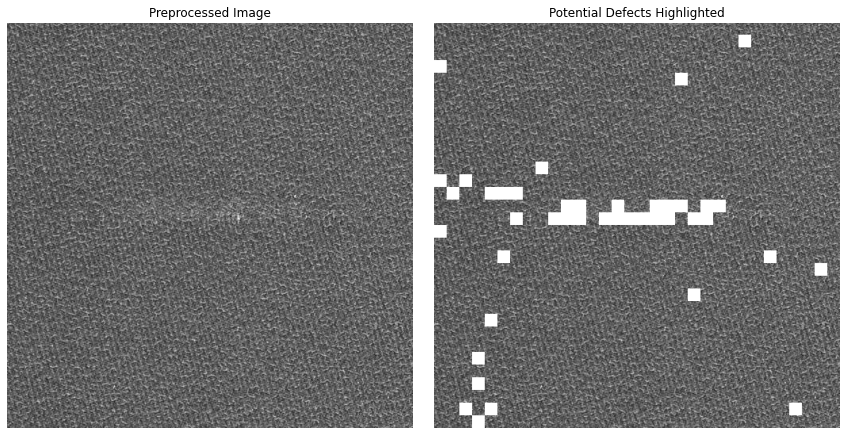

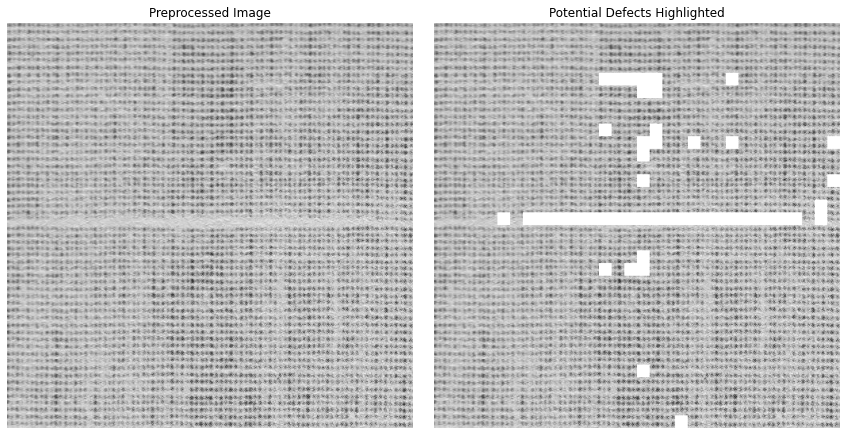

In [111]:
random_test()

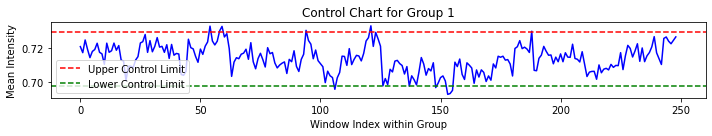

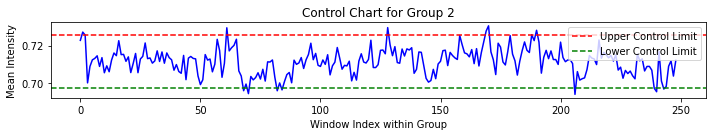

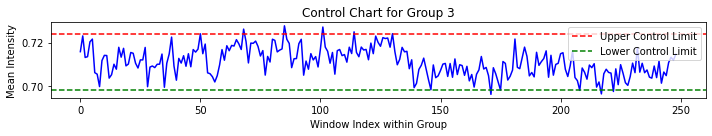

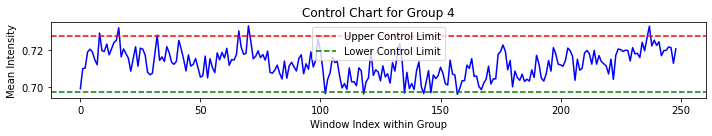

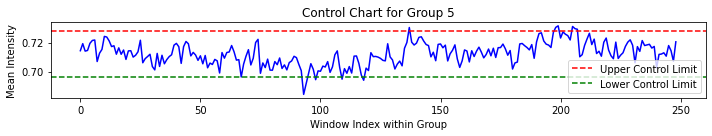

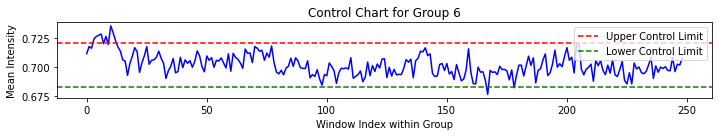

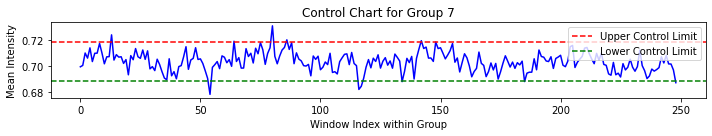

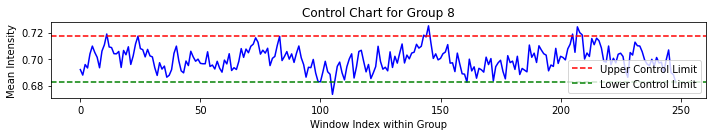

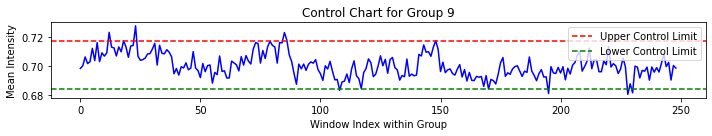

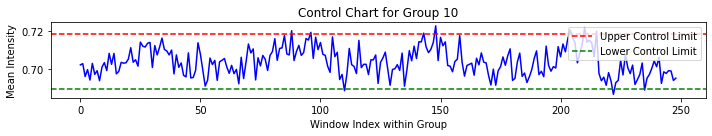

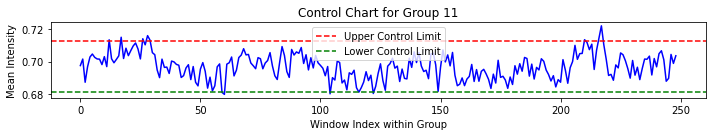

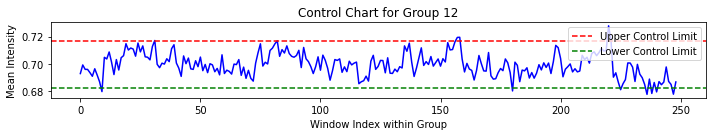

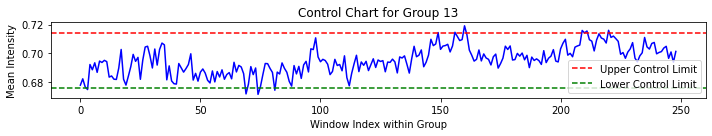

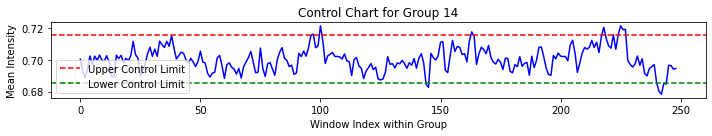

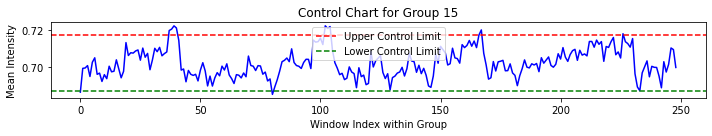

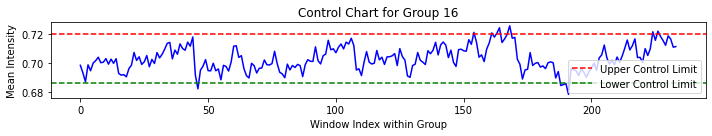

In [112]:
# Define the window size and the step size for sliding the window
window_size = 16  
step_size = 8  

# Initialize the list to hold the mean values for each window slide
sliding_mean_values = []
window_positions = []  # To keep track of the window positions for visualization

# Calculate the number of steps to slide the window based on the image size and step size
num_steps_x = (preprocessed_image.shape[1] - window_size) // step_size + 1
num_steps_y = (preprocessed_image.shape[0] - window_size) // step_size + 1

# Slide the window across the image and calculate the mean for each position
for y in range(num_steps_y):
    for x in range(num_steps_x):
        # Define the window boundaries
        start_x = x * step_size
        start_y = y * step_size
        end_x = start_x + window_size
        end_y = start_y + window_size

        # Extract the window from the image
        window = preprocessed_image[start_y:end_y, start_x:end_x]

        # Calculate the mean pixel intensity within the window and store it
        window_mean = np.mean(window)
        sliding_mean_values.append(window_mean)

        # Store the top-left corner position of the window for visualization
        window_positions.append((start_x, start_y))

# Calculate the new group size to fit exactly 32 groups
total_windows = len(sliding_mean_values)
group_size = total_windows // 16  # Integer division to determine the size of each group

# If the total number of windows is not a multiple of 32, we will have one smaller last group
if total_windows % 16 != 0:
    group_size += 1  # Increase the group size to ensure the last group has enough windows

# Recalculate the number of groups based on the new group size
num_groups = total_windows // group_size
if total_windows % group_size != 0:
    num_groups += 1  # We will have an additional group if there's a remainder

# Initialize lists to hold the group means and standard deviations for the new group size
group_means = []
group_std_devs = []
group_control_limits = []

# Calculate mean and standard deviation for each new group
for i in range(num_groups):
    # Extract the group
    group = sliding_mean_values[i * group_size:(i + 1) * group_size]
    
    # Calculate the group mean and standard deviation
    group_mean = np.mean(group)
    group_std_dev = np.std(group)
    
    # Append the group mean and standard deviation to the lists
    group_means.append(group_mean)
    group_std_devs.append(group_std_dev)
    
    # Calculate the control limits for this group
    upper_limit = group_mean + 2 * group_std_dev
    lower_limit = group_mean - 2 * group_std_dev
    group_control_limits.append((upper_limit, lower_limit))

# Create control charts for each group
for i, (group_mean, group_std_dev, limits) in enumerate(zip(group_means, group_std_devs, group_control_limits)):
    upper_limit, lower_limit = limits
    plt.figure(figsize=(10, 2))
    plt.plot(sliding_mean_values[i * group_size:(i + 1) * group_size], linestyle='-', color='blue')
    plt.axhline(upper_limit, color='red', linestyle='--', label='Upper Control Limit')
    plt.axhline(lower_limit, color='green', linestyle='--', label='Lower Control Limit')
    plt.title(f'Control Chart for Group {i+1}')
    plt.xlabel('Window Index within Group')
    plt.ylabel('Mean Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Identify and return any windows that are out of control within each group
out_of_control_points_by_group = []

for i, (group_mean, group_std_dev, limits) in enumerate(zip(group_means, group_std_devs, group_control_limits)):
    upper_limit, lower_limit = limits
    group = sliding_mean_values[i * group_size:(i + 1) * group_size]
    out_of_control_points = [(i * group_size + j, val) for j, val in enumerate(group)
                             if val < lower_limit or val > upper_limit]
    out_of_control_points_by_group.extend(out_of_control_points)

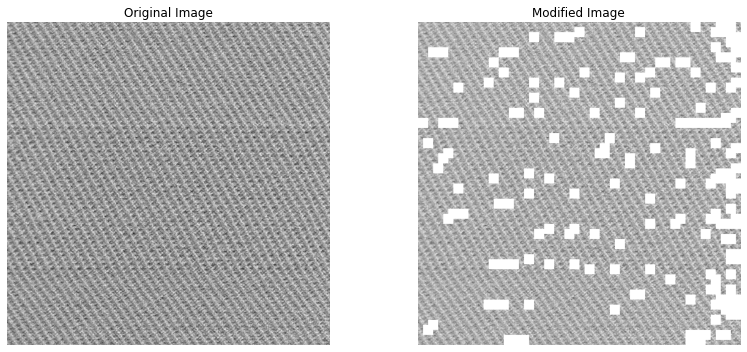

In [113]:
def process_and_display_image(image_path, window_size=16, step_size=8, num_groups=16):
    # Load the image

    color_image = Image.open(image_path)
    gray_image = color_image.convert('L')
    gray_image_array = np.array(gray_image)
    
    image_smoothed = gray_image_array

    # Sliding window technique
    sliding_mean_values = []
    window_positions = []
    num_steps_x = (image_smoothed.shape[1] - window_size) // step_size + 1
    num_steps_y = (image_smoothed.shape[0] - window_size) // step_size + 1

    for y in range(num_steps_y):
        for x in range(num_steps_x):
            start_x = x * step_size
            start_y = y * step_size
            window = image_smoothed[start_y:start_y + window_size, start_x:start_x + window_size]
            sliding_mean_values.append(np.mean(window))
            window_positions.append((start_x, start_y))

    # Group the windows and calculate mean for each group
    total_windows = len(sliding_mean_values)
    group_size = total_windows // num_groups if total_windows % num_groups == 0 else total_windows // num_groups + 1
    group_means = [np.mean(sliding_mean_values[i:i + group_size]) for i in range(0, total_windows, group_size)]

    # Calculate baseline statistics for each group
    group_std_devs = [np.std(sliding_mean_values[i:i + group_size]) for i in range(0, total_windows, group_size)]
    group_control_limits = [(mean + 2 * std, mean - 2 * std) for mean, std in zip(group_means, group_std_devs)]

    # Highlight anomalies by setting pixels to white
    for group_index, (upper_limit, lower_limit) in enumerate(group_control_limits):
        for i in range(group_index * group_size, min((group_index + 1) * group_size, total_windows)):
            mean_val = sliding_mean_values[i]
            if mean_val < lower_limit or mean_val > upper_limit:
                start_x, start_y = window_positions[i]
                end_x = min(start_x + window_size, gray_image_array.shape[1])
                end_y = min(start_y + window_size, gray_image_array.shape[0])
                gray_image_array[start_y:end_y, start_x:end_x] = 255  # Set to white

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    ax[0].imshow(gray_image, cmap='gray')
    ax[0].title.set_text('Original Image')
    ax[0].axis('off')

    # Modified image with patches processed
    ax[1].imshow(cv2.cvtColor(gray_image_array, cv2.COLOR_BGR2RGB))
    ax[1].title.set_text('Modified Image')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
process_and_display_image('0048.jpg')


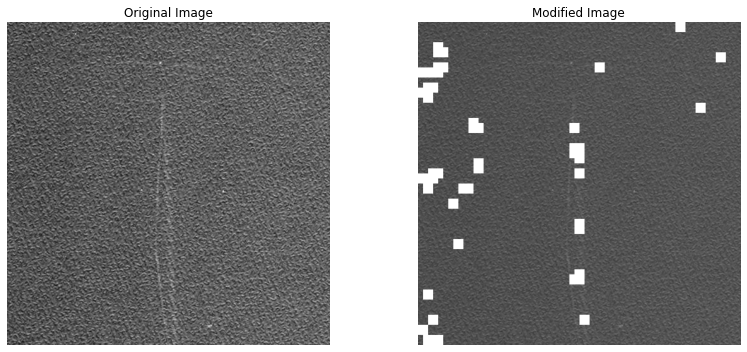

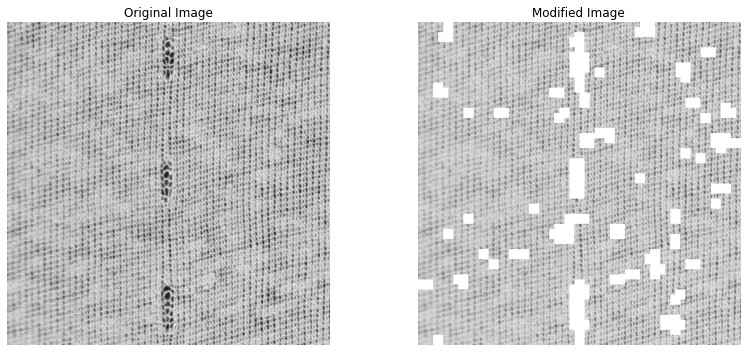

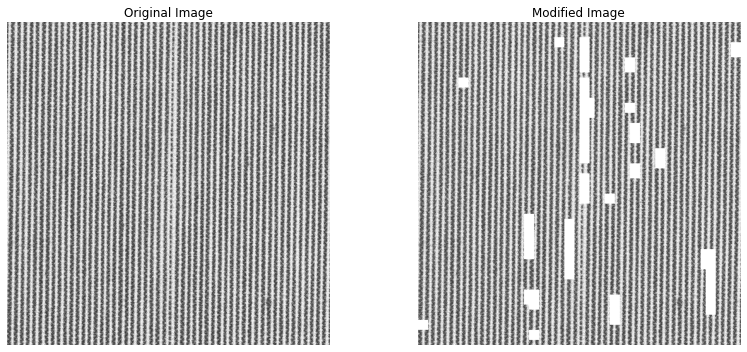

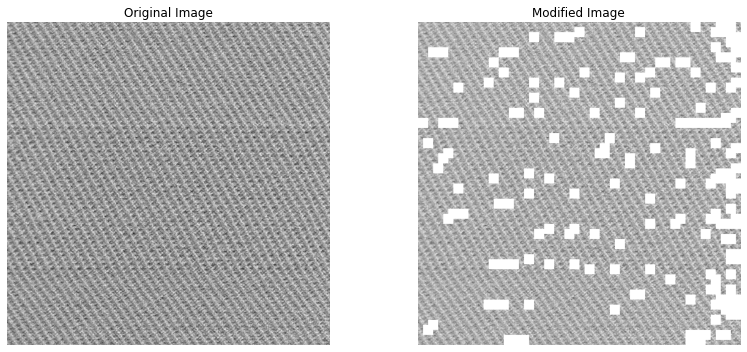

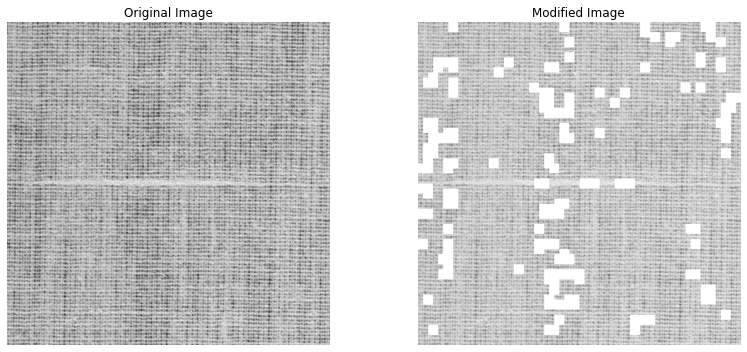

In [115]:
def random_test():
    counter = 0
    while counter < 5:
        try:
            random_int = np.random.randint(1, 196)
            string = ("0" * (4-len(str(random_int)))) + str(random_int)
            
            image_path = f'{string}.jpg'
            process_and_display_image(image_path)
        except:
            continue
        counter += 1
        
random_test()